In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from gtfparse import read_gtf
from matplotlib_venn import venn3, venn3_circles, venn2, venn2_circles
import bioframe
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import zscore

## DEGs

In [2]:
# Read GTF with gene annotation
genes = read_gtf('../gencode.vM25.annotation.gtf')
genes = genes[genes['feature'] == 'gene']
genes = genes[['seqname', 'start', 'end', 'strand', 'gene_id', 'gene_type', 'gene_name']]
genes.head()

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_type', 'gene_name', 'level', 'mgi_id', 'havana_gene', 'transcript_id', 'transcript_type', 'transcript_name', 'transcript_support_level', 'tag', 'havana_transcript', 'exon_number', 'exon_id', 'protein_id', 'ccdsid', 'ont']


,seqname,start,end,strand,gene_id,gene_type,gene_name
0,chr1,3073253,3074322,+,ENSMUSG00000102693.1,TEC,4933401J01Rik
3,chr1,3102016,3102125,+,ENSMUSG00000064842.1,snRNA,Gm26206
6,chr1,3205901,3671498,-,ENSMUSG00000051951.5,protein_coding,Xkr4
24,chr1,3252757,3253236,+,ENSMUSG00000102851.1,processed_pseudogene,Gm18956
27,chr1,3365731,3368549,-,ENSMUSG00000103377.1,TEC,Gm37180


### dTAG vs DMSO

In [3]:
degs_dtag_dmso = pd.read_csv('./degs/degs_dTAG_DMSO_DESeq.csv', sep = '\s+', header = 0)
degs_dtag_dmso['gene_id'] = degs_dtag_dmso.index
degs_dtag_dmso.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_id
ENSMUSG00000025902.13,35.529954,1.304048,0.528238,1.36129,0.173422,1.0,ENSMUSG00000025902.13
ENSMUSG00000102269.1,11.336473,-0.129831,0.665314,0.00000,1.000000,1.0,ENSMUSG00000102269.1
ENSMUSG00000103922.1,161.055743,-0.100274,0.204546,0.00000,1.000000,1.0,ENSMUSG00000103922.1
ENSMUSG00000033845.13,2913.554729,0.118679,0.081994,0.00000,1.000000,1.0,ENSMUSG00000033845.13
ENSMUSG00000102275.1,18.019009,0.100160,0.541625,0.00000,1.000000,1.0,ENSMUSG00000102275.1


In [4]:
degs_dtag_dmso = degs_dtag_dmso.merge(genes, on = 'gene_id')

columns_to_save = ['seqname', 'start', 'end', 'gene_name', 'gene_id', 'strand', 'gene_type', 'log2FoldChange', 'baseMean', 'pvalue', 'padj']
degs_dtag_dmso = degs_dtag_dmso[columns_to_save]

degs_dtag_dmso.sort_values('log2FoldChange').head()

,seqname,start,end,gene_name,gene_id,strand,gene_type,log2FoldChange,baseMean,pvalue,padj
9851,chr11,51059257,51072799,Zfp354a,ENSMUSG00000020364.14,+,protein_coding,-9.714415,78.614600,4.430078e-10,2.236912e-08
5454,chr6,108065045,108077122,Setmar,ENSMUSG00000034639.7,+,protein_coding,-9.442076,64.307210,1.722540e-09,8.485612e-08
3359,chr4,116702279,116708406,Mmachc,ENSMUSG00000028690.4,-,protein_coding,-8.012604,435.023369,6.388155e-56,1.984996e-53
1143,chr2,32095528,32110820,Plpp7,ENSMUSG00000051373.5,+,protein_coding,-7.412605,26.937988,5.979148e-06,2.068759e-04
393,chr1,87945119,88008551,Usp40,ENSMUSG00000005501.14,-,protein_coding,-6.837094,323.215673,8.681430e-36,1.576118e-33


In [5]:
degs_dtag_dmso_up = degs_dtag_dmso[(degs_dtag_dmso['padj'] < 0.01) & (degs_dtag_dmso['log2FoldChange'] > 0)]
degs_dtag_dmso_down = degs_dtag_dmso[(degs_dtag_dmso['padj'] < 0.01) & (degs_dtag_dmso['log2FoldChange'] < 0)]
degs_dtag_dmso_stable = degs_dtag_dmso[~degs_dtag_dmso['gene_id'].isin([x for x in degs_dtag_dmso['gene_id'].values \
                                                   if x in degs_dtag_dmso_down['gene_id'].values or x in degs_dtag_dmso_up['gene_id'].values])]

print('Up-regulated:', len(degs_dtag_dmso_up))
print('Down-regulated:', len(degs_dtag_dmso_down))
print('No change:', len(degs_dtag_dmso_stable))
print('Low expression:', len(genes) - len(degs_dtag_dmso))

Up-regulated: 142
Down-regulated: 476
No change: 15540
Low expression: 39243


In [6]:
degs_dtag_dmso_down.to_csv('./degs/degs_dtag_dmso_down.bed', header = 1, index = 0, sep = '\t')
degs_dtag_dmso_up.to_csv('./degs/degs_dtag_dmso_up.bed', header = 1, index = 0, sep = '\t')
degs_dtag_dmso_stable.to_csv('./degs/degs_dtag_dmso_stable.bed', header = 1, index = 0, sep = '\t')
degs_dtag_dmso[['gene_name', 'log2FoldChange']].sort_values(['log2FoldChange']).to_csv('./gsea/genes_dtag_dmso.ranked.rnk', sep = '\t', header = 0, index = 0)
degs_dtag_dmso[['gene_id', 'log2FoldChange']].sort_values(['log2FoldChange']).to_csv('./gsea/genes_dtag_dmso.ranked.ensid.rnk', sep = '\t', header = 0, index = 0)

### DMSO+RA vs DMSO

In [7]:
degs_ra_dmso = pd.read_csv('./degs/degs_RA_DMSO_DESeq.csv', sep = '\s+', header = 0)
degs_ra_dmso['gene_id'] = degs_ra_dmso.index
degs_ra_dmso.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_id
ENSMUSG00000025902.13,35.529954,2.065068,0.516780,2.864090,0.004182,0.012104,ENSMUSG00000025902.13
ENSMUSG00000102269.1,11.336473,-0.857022,0.709397,-0.383508,0.701343,1.000000,ENSMUSG00000102269.1
ENSMUSG00000103922.1,161.055743,-0.571352,0.212913,0.000000,1.000000,1.000000,ENSMUSG00000103922.1
ENSMUSG00000033845.13,2913.554729,-0.658939,0.083627,-0.884605,0.376370,0.731199,ENSMUSG00000033845.13
ENSMUSG00000102275.1,18.019009,-0.932877,0.594470,-0.585252,0.558378,1.000000,ENSMUSG00000102275.1


In [8]:
degs_ra_dmso = degs_ra_dmso.merge(genes, on = 'gene_id')

columns_to_save = ['seqname', 'start', 'end', 'gene_name', 'gene_id', 'strand', 'gene_type', 'log2FoldChange', 'baseMean', 'pvalue', 'padj']
degs_ra_dmso = degs_ra_dmso[columns_to_save]

degs_ra_dmso.sort_values('log2FoldChange').head()

,seqname,start,end,gene_name,gene_id,strand,gene_type,log2FoldChange,baseMean,pvalue,padj
6888,chr7,129398102,129403090,Gm33027,ENSMUSG00000108713.1,-,lincRNA,-9.428662,101.494471,1.449520e-09,9.141820e-09
12471,chr14,63492347,63509092,Tdh,ENSMUSG00000021953.14,-,protein_coding,-8.726673,10142.980427,9.777433e-285,2.633063e-281
12534,chr14,70890120,70979838,Gfra2,ENSMUSG00000022103.10,+,protein_coding,-8.040984,29.478589,6.348455e-07,3.094369e-06
549,chr1,133679091,133690108,Lax1,ENSMUSG00000051998.14,-,protein_coding,-7.978268,30.212858,8.031291e-07,3.881831e-06
3426,chr4,122008193,122009338,Gm12892,ENSMUSG00000083679.1,+,processed_pseudogene,-7.824598,15.876393,2.605648e-06,1.191343e-05


In [9]:
degs_ra_dmso_up = degs_ra_dmso[(degs_ra_dmso['padj'] < 0.01) & (degs_ra_dmso['log2FoldChange'] > 0)]
degs_ra_dmso_down = degs_ra_dmso[(degs_ra_dmso['padj'] < 0.01) & (degs_ra_dmso['log2FoldChange'] < 0)]
degs_ra_dmso_stable = degs_ra_dmso[~degs_ra_dmso['gene_id'].isin([x for x in degs_ra_dmso['gene_id'].values \
                                                   if x in degs_ra_dmso_down['gene_id'].values or x in degs_ra_dmso_up['gene_id'].values])]

print('Up-regulated:', len(degs_ra_dmso_up))
print('Down-regulated:', len(degs_ra_dmso_down))
print('No change:', len(degs_ra_dmso_stable))
print('Low expression:', len(genes) - len(degs_ra_dmso))

Up-regulated: 3228
Down-regulated: 2270
No change: 10660
Low expression: 39243


In [10]:
degs_ra_dmso_down.to_csv('./degs/degs_ra_dmso_down.bed', header = 1, index = 0, sep = '\t')
degs_ra_dmso_up.to_csv('./degs/degs_ra_dmso_up.bed', header = 1, index = 0, sep = '\t')
degs_ra_dmso_stable.to_csv('./degs/degs_ra_dmso_stable.bed', header = 1, index = 0, sep = '\t')
degs_ra_dmso[['gene_name', 'log2FoldChange']].sort_values(['log2FoldChange']).to_csv('./gsea/genes_ra_dmso.ranked.rnk', sep = '\t', header = 0, index = 0)
degs_ra_dmso[['gene_id', 'log2FoldChange']].sort_values(['log2FoldChange']).to_csv('./gsea/genes_ra_dmso.ranked.ensid.rnk', sep = '\t', header = 0, index = 0)

### dTAG+RA vs dTAG

In [11]:
degs_ra_dtag = pd.read_csv('./degs/degs_RA_dTAG_DESeq.csv', sep = '\s+', header = 0)
degs_ra_dtag['gene_id'] = degs_ra_dtag.index
degs_ra_dtag.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_id
ENSMUSG00000025902.13,35.529954,1.840701,0.401967,3.123985,0.001784,0.005559,ENSMUSG00000025902.13
ENSMUSG00000102269.1,11.336473,-1.853844,0.779059,-1.628736,0.103369,0.235344,ENSMUSG00000102269.1
ENSMUSG00000103922.1,161.055743,-0.372240,0.207480,0.000000,1.000000,1.000000,ENSMUSG00000103922.1
ENSMUSG00000033845.13,2913.554729,-0.727567,0.082642,-1.725563,0.084426,0.195891,ENSMUSG00000033845.13
ENSMUSG00000102275.1,18.019009,-0.372369,0.544183,0.000000,1.000000,1.000000,ENSMUSG00000102275.1


In [12]:
degs_ra_dtag = degs_ra_dtag.merge(genes, on = 'gene_id')

columns_to_save = ['seqname', 'start', 'end', 'gene_name', 'gene_id', 'strand', 'gene_type', 'log2FoldChange', 'baseMean', 'pvalue', 'padj']
degs_ra_dtag = degs_ra_dtag[columns_to_save]

degs_ra_dtag.sort_values('log2FoldChange').head()

,seqname,start,end,gene_name,gene_id,strand,gene_type,log2FoldChange,baseMean,pvalue,padj
6888,chr7,129398102,129403090,Gm33027,ENSMUSG00000108713.1,-,lincRNA,-10.611892,101.494471,6.546051e-12,4.949513e-11
11368,chr12,104263122,104269372,Serpina3i,ENSMUSG00000079014.4,+,protein_coding,-9.182421,30.902915,8.381431e-09,4.809203e-08
1243,chr2,51420984,51438785,1700057H21Rik,ENSMUSG00000086007.1,-,lincRNA,-8.236522,17.255173,5.811218e-07,2.756022e-06
1499,chr2,109902396,109913319,Platr8,ENSMUSG00000063751.6,-,processed_transcript,-8.230798,22.239196,4.330447e-07,2.086206e-06
12038,chr13,102693558,102739629,Cd180,ENSMUSG00000021624.9,+,protein_coding,-8.180929,22.041890,5.327090e-07,2.540588e-06


In [13]:
degs_ra_dtag_up = degs_ra_dtag[(degs_ra_dtag['padj'] < 0.01) & (degs_ra_dtag['log2FoldChange'] > 0)]
degs_ra_dtag_down = degs_ra_dtag[(degs_ra_dtag['padj'] < 0.01) & (degs_ra_dtag['log2FoldChange'] < 0)]
degs_ra_dtag_stable = degs_ra_dtag[~degs_ra_dtag['gene_id'].isin([x for x in degs_ra_dtag['gene_id'].values \
                                                   if x in degs_ra_dtag_down['gene_id'].values or x in degs_ra_dtag_up['gene_id'].values])]

print('Up-regulated:', len(degs_ra_dtag_up))
print('Down-regulated:', len(degs_ra_dtag_down))
print('No change:', len(degs_ra_dtag_stable))
print('Low expression:', len(genes) - len(degs_ra_dtag))

Up-regulated: 3312
Down-regulated: 2122
No change: 10724
Low expression: 39243


In [14]:
degs_ra_dtag_down.to_csv('./degs/degs_ra_dtag_down.bed', header = 1, index = 0, sep = '\t')
degs_ra_dtag_up.to_csv('./degs/degs_ra_dtag_up.bed', header = 1, index = 0, sep = '\t')
degs_ra_dtag_stable.to_csv('./degs/degs_ra_dtag_stable.bed', header = 1, index = 0, sep = '\t')
degs_ra_dtag[['gene_name', 'log2FoldChange']].sort_values(['log2FoldChange']).to_csv('./gsea/genes_ra_dtag.ranked.rnk', sep = '\t', header = 0, index = 0)
degs_ra_dtag[['gene_id', 'log2FoldChange']].sort_values(['log2FoldChange']).to_csv('./gsea/genes_ra_dtag.ranked.ensid.rnk', sep = '\t', header = 0, index = 0)

### dTAG+RA vs DMSO+RA

In [15]:
degs_ra_dtag_dmso = pd.read_csv('./degs/degs_RA_dTAG_DMSO_DESeq.csv', sep = '\s+', header = 0)
degs_ra_dtag_dmso['gene_id'] = degs_ra_dtag_dmso.index
degs_ra_dtag_dmso.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_id
ENSMUSG00000025902.13,35.529954,1.079681,0.386787,1.279048,0.200880,0.914315,ENSMUSG00000025902.13
ENSMUSG00000102269.1,11.336473,-1.126653,0.817028,-0.663001,0.507330,1.000000,ENSMUSG00000102269.1
ENSMUSG00000103922.1,161.055743,0.098838,0.215734,0.000000,1.000000,1.000000,ENSMUSG00000103922.1
ENSMUSG00000033845.13,2913.554729,0.050051,0.084262,0.000000,1.000000,1.000000,ENSMUSG00000033845.13
ENSMUSG00000102275.1,18.019009,0.660668,0.596801,0.126853,0.899057,1.000000,ENSMUSG00000102275.1


In [16]:
degs_ra_dtag_dmso = degs_ra_dtag_dmso.merge(genes, on = 'gene_id')

columns_to_save = ['seqname', 'start', 'end', 'gene_name', 'gene_id', 'strand', 'gene_type', 'log2FoldChange', 'baseMean', 'pvalue', 'padj']
degs_ra_dtag_dmso = degs_ra_dtag_dmso[columns_to_save]

degs_ra_dtag_dmso.sort_values('log2FoldChange').head()

,seqname,start,end,gene_name,gene_id,strand,gene_type,log2FoldChange,baseMean,pvalue,padj
7316,chr8,67494858,67502584,Nat2,ENSMUSG00000051147.10,+,protein_coding,-8.319345,22.548272,3.064867e-07,6.068886e-06
11857,chr13,67278577,67283361,F630042J09Rik,ENSMUSG00000114442.1,+,lincRNA,-6.490509,15.236500,1.231574e-04,1.565678e-03
3359,chr4,116702279,116708406,Mmachc,ENSMUSG00000028690.4,-,protein_coding,-6.241004,435.023369,2.009633e-52,7.551546e-50
15876,chrX,95639193,95658509,Zc4h2,ENSMUSG00000035062.13,-,protein_coding,-5.893397,110.197528,7.863406e-22,5.909624e-20
1454,chr2,101560781,101649532,B230118H07Rik,ENSMUSG00000027165.16,-,protein_coding,-5.353853,115.439603,2.101924e-28,2.279389e-26


In [17]:
degs_ra_dtag_dmso_up = degs_ra_dtag_dmso[(degs_ra_dtag_dmso['padj'] < 0.01) & (degs_ra_dtag_dmso['log2FoldChange'] > 0)]
degs_ra_dtag_dmso_down = degs_ra_dtag_dmso[(degs_ra_dtag_dmso['padj'] < 0.01) & (degs_ra_dtag_dmso['log2FoldChange'] < 0)]
degs_ra_dtag_dmso_stable = degs_ra_dtag_dmso[~degs_ra_dtag_dmso['gene_id'].isin([x for x in degs_ra_dtag_dmso['gene_id'].values \
                                                      if x in degs_ra_dtag_dmso_down['gene_id'].values or x in degs_ra_dtag_dmso_up['gene_id'].values])]

print('Up-regulated:', len(degs_ra_dtag_dmso_up))
print('Down-regulated:', len(degs_ra_dtag_dmso_down))
print('No change:', len(degs_ra_dtag_dmso_stable))
print('No expression:', len(genes) - len(degs_ra_dtag_dmso))

Up-regulated: 794
Down-regulated: 768
No change: 14596
No expression: 39243


In [18]:
degs_ra_dtag_dmso_down.to_csv('./degs/degs_ra_dtag_dmso_down.bed', header = 1, index = 0, sep = '\t')
degs_ra_dtag_dmso_up.to_csv('./degs/degs_ra_dtag_dmso_up.bed', header = 1, index = 0, sep = '\t')
degs_ra_dtag_dmso_stable.to_csv('./degs/degs_ra_dtag_dmso_stable.bed', header = 1, index = 0, sep = '\t')
degs_ra_dtag_dmso[['gene_name', 'log2FoldChange']].sort_values(['log2FoldChange']).to_csv('./gsea/genes_ra_dtag_dmso.ranked.rnk', sep = '\t', header = 0, index = 0)
degs_ra_dtag_dmso[['gene_id', 'log2FoldChange']].sort_values(['log2FoldChange']).to_csv('./gsea/genes_ra_dtag_dmso.ranked.ensid.rnk', sep = '\t', header = 0, index = 0)

## PCA

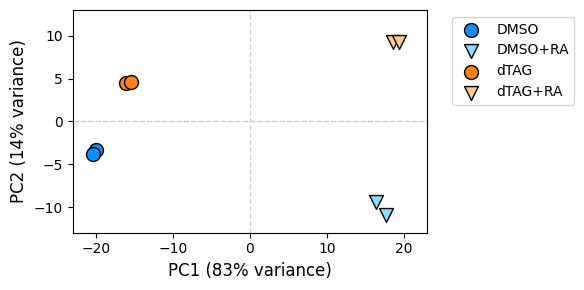

In [19]:
pca = pd.read_csv('/DATA/users/magnitov/znf143/rnaseq/degs/pca_values.txt', sep = '\s+')

plt.figure(figsize = (6, 3))

plt.scatter(pca[pca['group'] == 'DMSO']['PC1'], pca[pca['group'] == 'DMSO']['PC2'], label = 'DMSO',
            edgecolor = 'k', marker = 'o', s = 100, color = '#0E8DFF')
plt.scatter(pca[pca['group'] == 'DMSO_RA']['PC1'], pca[pca['group'] == 'DMSO_RA']['PC2'], label = 'DMSO+RA',
            edgecolor = 'k', marker = 'v', s = 100, color = '#87DEFF')
plt.scatter(pca[pca['group'] == 'dTAG']['PC1'], pca[pca['group'] == 'dTAG']['PC2'], label = 'dTAG',
            edgecolor = 'k', marker = 'o', s = 100, color = '#FF800E')
plt.scatter(pca[pca['group'] == 'dTAG_RA']['PC1'], pca[pca['group'] == 'dTAG_RA']['PC2'], label = 'dTAG+RA',
            edgecolor = 'k', marker = 'v', s = 100, color = '#FFCA87')
plt.legend(bbox_to_anchor = (1.05, 1))
plt.axhline(0, color = '#CCCCCC', lw = 1, ls = '--')
plt.axvline(0, color = '#CCCCCC', lw = 1, ls = '--')
plt.xlabel('PC1 (83% variance)', fontsize = 12)
plt.ylabel('PC2 (14% variance)', fontsize = 12)
plt.xlim((-23, 23))
plt.ylim((-13, 13))

plt.tight_layout()
plt.show()

## Volcano plots

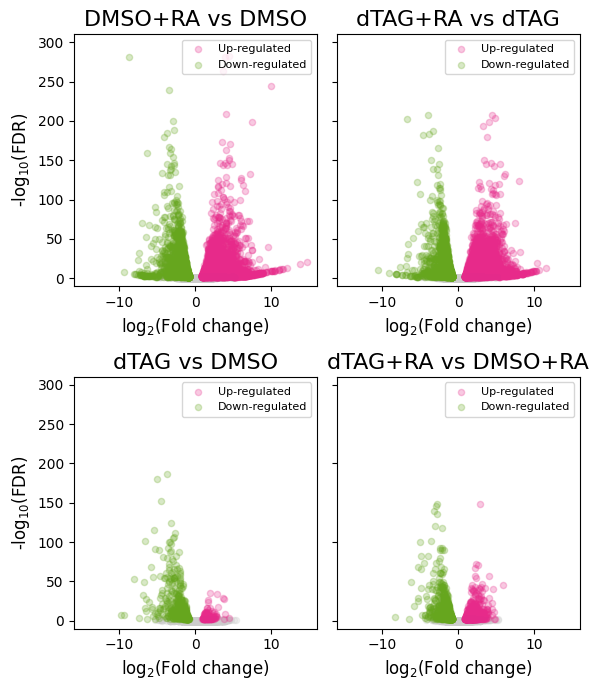

In [20]:
plt.figure(figsize = (6, 7))

plt.subplot(221)
plt.title('DMSO+RA vs DMSO', fontsize = 16)
plt.scatter(degs_ra_dmso_stable['log2FoldChange'], -np.log10(degs_ra_dmso_stable['padj']), 
            color = '#CCCCCC', label = '_nolegend_', alpha = 0.25, s = 20)
plt.scatter(degs_ra_dmso_up['log2FoldChange'], -np.log10(degs_ra_dmso_up['padj']), 
            color = '#E72A8A', label = 'Up-regulated', alpha = 0.25, s = 20)
plt.scatter(degs_ra_dmso_down['log2FoldChange'], -np.log10(degs_ra_dmso_down['padj']), 
            color = '#66A61E', label = 'Down-regulated', alpha = 0.25, s = 20)

plt.xlabel('log$_2$(Fold change)', fontsize = 12)
plt.xlim((-16, 16))
plt.ylim((-10, 310))
plt.ylabel('-log$_{10}$(FDR)', fontsize = 12)
plt.legend(loc = 'upper right', fontsize = 8)

plt.subplot(222)
plt.title('dTAG+RA vs dTAG', fontsize = 16)
plt.scatter(degs_ra_dtag_stable['log2FoldChange'], -np.log10(degs_ra_dtag_stable['padj']), 
            color = '#CCCCCC', label = '_nolegend_', alpha = 0.25, s = 20)
plt.scatter(degs_ra_dtag_up['log2FoldChange'], -np.log10(degs_ra_dtag_up['padj']), 
            color = '#E72A8A', label = 'Up-regulated', alpha = 0.25, s = 20)
plt.scatter(degs_ra_dtag_down['log2FoldChange'], -np.log10(degs_ra_dtag_down['padj']), 
            color = '#66A61E', label = 'Down-regulated', alpha = 0.25, s = 20)

plt.xlabel('log$_2$(Fold change)', fontsize = 12)
plt.xlim((-16, 16))
plt.ylim((-10, 310))
plt.yticks([0, 50, 100, 150, 200, 250, 300], [])
plt.legend(loc = 'upper right', fontsize = 8)

plt.subplot(223)
plt.title('dTAG vs DMSO', fontsize = 16)
plt.scatter(degs_dtag_dmso_stable['log2FoldChange'], -np.log10(degs_dtag_dmso_stable['padj']), 
            color = '#CCCCCC', label = '_nolegend_', alpha = 0.25, s = 20)
plt.scatter(degs_dtag_dmso_up['log2FoldChange'], -np.log10(degs_dtag_dmso_up['padj']), 
            color = '#E72A8A', label = 'Up-regulated', alpha = 0.25, s = 20)
plt.scatter(degs_dtag_dmso_down['log2FoldChange'], -np.log10(degs_dtag_dmso_down['padj']), 
            color = '#66A61E', label = 'Down-regulated', alpha = 0.25, s = 20)

plt.xlabel('log$_2$(Fold change)', fontsize = 12)
plt.xlim((-16, 16))
plt.ylim((-10, 310))
plt.ylabel('-log$_{10}$(FDR)', fontsize = 12)
plt.legend(loc = 'upper right', fontsize = 8)

plt.subplot(224)
plt.title('dTAG+RA vs DMSO+RA', fontsize = 16)
plt.scatter(degs_ra_dtag_dmso_stable['log2FoldChange'], -np.log10(degs_ra_dtag_dmso_stable['padj']), 
            color = '#CCCCCC', label = '_nolegend_', alpha = 0.25, s = 20)
plt.scatter(degs_ra_dtag_dmso_up['log2FoldChange'], -np.log10(degs_ra_dtag_dmso_up['padj']), 
            color = '#E72A8A', label = 'Up-regulated', alpha = 0.25, s = 20)
plt.scatter(degs_ra_dtag_dmso_down['log2FoldChange'], -np.log10(degs_ra_dtag_dmso_down['padj']), 
            color = '#66A61E', label = 'Down-regulated', alpha = 0.25, s = 20)

plt.xlabel('log$_2$(Fold change)', fontsize = 12)
plt.xlim((-16, 16))
plt.ylim((-10, 310))
plt.yticks([0, 100, 200, 300], [])
plt.legend(loc = 'upper right', fontsize = 8)

plt.tight_layout()
plt.show()

## Overlap of DEGs

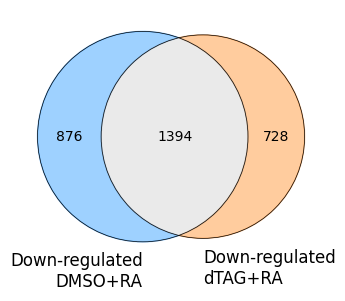

In [21]:
down_ra_dmso = set(list(degs_ra_dmso_down['gene_id'].values))
down_ra_dtag = set(list(degs_ra_dtag_down['gene_id'].values))

plt.figure(figsize = (4, 4))
v = venn2([down_ra_dmso, down_ra_dtag], ('Down-regulated\nDMSO+RA', 'Down-regulated\ndTAG+RA'))
venn2_circles([down_ra_dmso, down_ra_dtag], lw = 0.5)
v.get_patch_by_id('10').set_color('#0E8DFF')
v.get_patch_by_id('01').set_color('#FF800E')
v.get_patch_by_id('11').set_color('#CCCCCC')
plt.show()

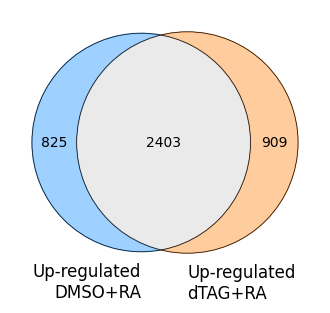

In [22]:
up_ra_dmso = set(list(degs_ra_dmso_up['gene_id'].values))
up_ra_dtag = set(list(degs_ra_dtag_up['gene_id'].values))

plt.figure(figsize = (4, 4))
v = venn2([up_ra_dmso, up_ra_dtag], ('Up-regulated\nDMSO+RA', 'Up-regulated\ndTAG+RA'))
venn2_circles([up_ra_dmso, up_ra_dtag], lw = 0.5)
v.get_patch_by_id('10').set_color('#0E8DFF')
v.get_patch_by_id('01').set_color('#FF800E')
v.get_patch_by_id('11').set_color('#CCCCCC')
plt.show()

## Scatter of fold-changes

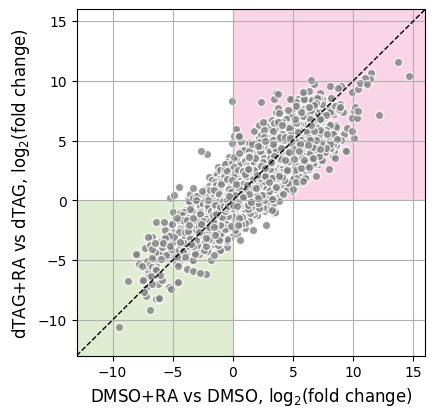

In [23]:
plt.figure(figsize = (4.5, 4.5))
plt.scatter(degs_ra_dmso['log2FoldChange'], degs_ra_dtag['log2FoldChange'], 
            color = 'grey', alpha = 0.8, edgecolor = 'w', lw = 1)
plt.plot([-20, 20], [-20, 20], color = 'k', lw = 1, ls = '--', zorder = 3)
plt.xlabel('DMSO+RA vs DMSO, log$_2$(fold change)', fontsize = 12)
plt.ylabel('dTAG+RA vs dTAG, log$_2$(fold change)', fontsize = 12)
plt.fill_between([0, 20], 0, 20, facecolor = '#E72A8A', zorder = 0, alpha = 0.2)
plt.fill_between([-20, 0], -20, 0, facecolor = '#66A61E', zorder = 0, alpha = 0.2)
plt.xlim((-13, 16))
plt.ylim((-13, 16))
plt.grid(zorder = 0)
plt.show()